In [16]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [17]:
raw_data = pd.read_csv('climate.csv')

print(raw_data.columns)
len(raw_data)

Index(['STATIONS_ID', 'MESS_DATUM', 'QN_3', 'FX', 'FM', 'QN_4', 'RSK', 'RSKF',
       'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM', 'TXK', 'TNK', 'TGK',
       'eor'],
      dtype='object')


41272

In [18]:
raw_data.describe()

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
count,41272.000000,4.127200e+04,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000
mean,1032.063384,1.958882e+07,-364.834537,-401.516769,-374.527428,6.294679,0.043497,-0.061616,-267.242872,-258.293734,5.017753,4.605340,568.424055,9.878412,71.752351,13.764351,6.389436,-272.180994
std,3791.337549,3.721780e+05,485.738307,496.634900,485.825334,2.412281,46.922249,47.037222,445.828523,437.855465,18.634642,73.233131,813.895941,6.773565,77.817833,7.854805,6.133130,448.738612
min,3.000000,1.891010e+07,-999.000000,-999.000000,-999.000000,1.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-15.800000,-999.000000,-12.800000,-20.400000,-999.000000
25%,3.000000,1.934040e+07,-999.000000,-999.000000,-999.000000,5.000000,0.000000,0.000000,-999.000000,-999.000000,4.000000,6.900000,974.600000,4.900000,70.000000,7.875000,2.000000,-999.000000
50%,3.000000,1.962070e+07,5.000000,6.200000,1.700000,5.000000,0.100000,1.000000,1.000000,0.000000,5.800000,9.400000,988.700000,10.100000,78.000000,13.800000,6.700000,1.600000
75%,3.000000,1.990100e+07,10.000000,11.300000,3.500000,10.000000,2.500000,6.000000,5.800000,0.000000,7.300000,12.700000,995.400000,15.000000,86.000000,19.600000,11.100000,8.000000
max,15000.000000,2.018123e+07,10.000000,41.700000,14.200000,10.000000,68.000000,8.000000,16.100000,43.000000,8.000000,26.000000,1021.000000,29.600000,100.000000,37.200000,24.500000,21.800000


In [19]:
key_meanings = {
    'MESS_DATUM': 'Datum',
    'QN_3': 'Messqualitaet1', # https://www.dwd.de/DE/leistungen/klimadatendeutschland/qualitaetsniveau.html?nn=16102
    'FX': 'Windgeschw Max', # m/sec
    'FM': 'Windgeschw Mittel', # m/sec
    'QN_4': 'Messqualitaet2', #
    'RSK': 'Niederschlag', # mm
    'RSKF': 'Niederschlagsform',
    'SDK': 'Sonnenstunden',
    'SHK_TAG': 'Schneehoehe', #cm
    'NM': 'Bedeckungsgrad',
    'VPM': 'Dampfdruck Mittel', #hpa
    'PM': 'Luftdruck Mittel',
    'TMK': 'Lufttemp Mittel',
    'UPM': 'Relative Feuchte', #%
    'TXK': 'Lufttemp Max', #°C
    'TNK': 'Lufttemp Min', #°C
    'TGK': 'Lufttemp Min Erdboden' #°C
}

QN_meaning_full = {
    0: 'Testdaten, keine Routineprodukte oder -daten',
    1: 'Daten, die keine systematische Prüfung und Korrektur enthalten. Es gibt einzelne beanstandete, korrigierte und bestätigte, aber auch ungeprüfte Werte. Die einzelnen Werte werden nicht durch Qualitätsbytes gekennzeichnet.',
    2: 'Daten, die nach individuellen Kriterien geprüft und ggf. korrigiert sind. Es gibt aber keine systematische Vergabe von Qualitätsbytes. Gilt vor allem für historische Daten, die keine systematische EDV-gestützte Prüfung durchlaufen haben.',
    3: 'Daten, die für einzelne (insbesondere automatisch gemessene) Elemente systematisch grob geprüft und ggf. korrigiert sind. Die Daten enthalten aber auch ungeprüfte Werte ohne Qualitätsbytes.',
    4: '',
    5: 'Historische subjektive Verfahren der Qualitätssicherung. Keine IT-gestützte Prüfung.',
    6: '',
    7: 'Daten, die systematisch geprüft sind. Alle Werte werden mit Qualitätsbytes versehen. Beanstandete Werte sind gekennzeichnet, aber in der Regel noch nicht korrigiert.',
    8: 'Daten, die systematisch geprüft sind. Alle Werte werden mit Qualitätsbytes versehen. Beanstandete Werte sind gekennzeichnet, aber nur teilweise korrigiert.',
    9: 'Daten, die systematisch geprüft sind. Alle Werte werden mit Qualitätsbytes versehen. Die wesentlichen Elemente sind systematisch korrigiert. Für einzelne Elemente ist keine systematische Korrektur vorgesehen.',
    10: 'Daten, die systematisch geprüft und ggf. korrigiert oder bestätigt sind. Die Qualitätsprüfung entspricht der zur jeweiligen Zeit gültigen Verfahren.',
    16: 'Homogenisierte Monatswerte.'
}

RSKF_meaning_full = {
    0: 'kein Niederschlag (konventionelle oder automatische Messung)',
    1: 'nur Regen (in historischen Daten vor dem 01.01.1979)',
    4: 'Form des Niederschlages nicht bekannt, obwohl Niederschlag gemeldet',
    6: 'nur Regen; flüssiger Niederschlag bei automatischer Messung',
    7: 'nur Schnee; fester Niederschlag bei automatischer Messung',
    8: 'Regen und Schnee und/oder Schneeregen; flüssig und fester Niederschlag bei automatischer Messung',
    9: 'Fehlkennung; fehlender Wert oder Niederschlagsform nicht feststellbar bei automatischer Messung'
}

NM_meaning_full = {
    0: 'wolkenlos',
    1: 'sonnig',
    2: 'heiter',
    3: 'leicht bewölkt',
    4: 'wolkig',
    5: 'bewölkt',
    6: 'stark bewölkt',
    7: 'fast bedeckt',
    8: 'bedeckt',
    9: 'Himmel nicht erkennbar'
}

### Clear data

In [20]:
# Drop ID (is irrelevant in our case)
# Drop eor (only singular value)
# Drop QN_3 (convered by QN_4)
# Drop QN_4 (we don't actually need those)
raw_data.drop(['STATIONS_ID', 'eor', 'QN_3', 'QN_4'], axis=1, inplace=True)

### Clear NaN

In [21]:
# Replace -999 by NaN
raw_data.replace(-999, np.nan, inplace=True)

# Fill NaN forward
raw_data.fillna(method='pad', inplace=True)

# For each column, find the last NaN value.
nan_indices = {c: raw_data[c].isna().idxmin()-1 for c in raw_data.columns}

# For the rest of the NaN values, approximate them by taking the value from the next year.
for i in range(max(nan_indices.values()), -1, -1):
    raw_data.loc[i] = raw_data.loc[i].fillna(raw_data.loc[i+365])

In [22]:
raw_data.describe()

,MESS_DATUM,FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
count,4.127200e+04,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000
mean,1.958882e+07,10.907896,3.687648,2.221971,2.141064,4.476279,1.002520,5.358568,9.958032,991.407494,9.878412,77.284528,13.764351,6.389436,4.612900
std,3.721780e+05,4.940848,1.966453,4.518106,2.718331,4.198026,2.988917,2.276471,3.824868,8.599613,6.773565,11.654976,7.854805,6.133130,6.237777
min,1.891010e+07,1.500000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000,942.800000,-15.800000,19.000000,-12.800000,-20.400000,-27.000000
25%,1.934040e+07,7.200000,2.100000,0.000000,0.000000,0.500000,0.000000,4.000000,6.900000,986.700000,4.900000,70.000000,7.875000,2.000000,0.200000
50%,1.962070e+07,10.100000,3.300000,0.100000,1.000000,3.500000,0.000000,5.800000,9.500000,993.000000,10.100000,78.000000,13.800000,6.700000,4.900000
75%,1.990100e+07,13.900000,5.300000,2.500000,6.000000,7.500000,0.000000,7.300000,12.700000,996.300000,15.000000,86.000000,19.600000,11.100000,9.500000
max,2.018123e+07,41.700000,14.200000,68.000000,8.000000,16.100000,43.000000,8.000000,26.000000,1021.000000,29.600000,100.000000,37.200000,24.500000,21.800000


### Scale data

In [23]:
# Convert date to actual datetime object
raw_data['MESS_DATUM'] = pd.to_datetime(raw_data['MESS_DATUM'], format='%Y%m%d')

In [24]:
raw_data.describe()

,FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
count,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000
mean,10.907896,3.687648,2.221971,2.141064,4.476279,1.002520,5.358568,9.958032,991.407494,9.878412,77.284528,13.764351,6.389436,4.612900
std,4.940848,1.966453,4.518106,2.718331,4.198026,2.988917,2.276471,3.824868,8.599613,6.773565,11.654976,7.854805,6.133130,6.237777
min,1.500000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000,942.800000,-15.800000,19.000000,-12.800000,-20.400000,-27.000000
25%,7.200000,2.100000,0.000000,0.000000,0.500000,0.000000,4.000000,6.900000,986.700000,4.900000,70.000000,7.875000,2.000000,0.200000
50%,10.100000,3.300000,0.100000,1.000000,3.500000,0.000000,5.800000,9.500000,993.000000,10.100000,78.000000,13.800000,6.700000,4.900000
75%,13.900000,5.300000,2.500000,6.000000,7.500000,0.000000,7.300000,12.700000,996.300000,15.000000,86.000000,19.600000,11.100000,9.500000
max,41.700000,14.200000,68.000000,8.000000,16.100000,43.000000,8.000000,26.000000,1021.000000,29.600000,100.000000,37.200000,24.500000,21.800000


In [25]:
# Scale temperature
raw_data[['TMK', 'TXK', 'TNK', 'TGK']] /= 50

# Scale wind speed
raw_data[['FX', 'FM']] /= 25
raw_data[['FX', 'FM']] -= 1

# Scale sun hours
raw_data['SDK'] /= 12
raw_data['SDK'] -= 1

# Scale humidity
raw_data['UPM'] /= 50
raw_data['UPM'] -= 1

# Scale rain fall
raw_data['RSK'] /= 50
raw_data['RSK'] -= 1

# Scale snow fall
raw_data['SHK_TAG'] /= 50
raw_data['SHK_TAG'] -= 1

# Scale pressure
raw_data['VPM'] /= 50
raw_data['VPM'] -= 1

raw_data['PM'] /= 1000
raw_data['PM'] -= 1

# Scale overcast
raw_data['NM'] /= 4
raw_data['NM'] -= 1

# Categorical data
raw_data['RSKF'] = pd.Categorical(raw_data['RSKF'])

In [26]:
raw_data.describe()

,FX,FM,RSK,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
count,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000
mean,-0.563684,-0.852494,-0.955561,-0.626977,-0.979950,0.339642,-0.800839,-0.008593,0.197568,0.545691,0.275287,0.127789,0.092258
std,0.197634,0.078658,0.090362,0.349836,0.059778,0.569118,0.076497,0.008600,0.135471,0.233100,0.157096,0.122663,0.124756
min,-0.940000,-0.996000,-1.000000,-1.000000,-1.000000,-1.000000,-0.976000,-0.057200,-0.316000,-0.620000,-0.256000,-0.408000,-0.540000
25%,-0.712000,-0.916000,-1.000000,-0.958333,-1.000000,0.000000,-0.862000,-0.013300,0.098000,0.400000,0.157500,0.040000,0.004000
50%,-0.596000,-0.868000,-0.998000,-0.708333,-1.000000,0.450000,-0.810000,-0.007000,0.202000,0.560000,0.276000,0.134000,0.098000
75%,-0.444000,-0.788000,-0.950000,-0.375000,-1.000000,0.825000,-0.746000,-0.003700,0.300000,0.720000,0.392000,0.222000,0.190000
max,0.668000,-0.432000,0.360000,0.341667,-0.140000,1.000000,-0.480000,0.021000,0.592000,1.000000,0.744000,0.490000,0.436000


### Rename columns

In [27]:
raw_data.columns = [key_meanings[c] for c in raw_data.columns]

In [28]:
raw_data.describe()

,Windgeschw Max,Windgeschw Mittel,Niederschlag,Sonnenstunden,Schneehoehe,Bedeckungsgrad,Dampfdruck Mittel,Luftdruck Mittel,Lufttemp Mittel,Relative Feuchte,Lufttemp Max,Lufttemp Min,Lufttemp Min Erdboden
count,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000
mean,-0.563684,-0.852494,-0.955561,-0.626977,-0.979950,0.339642,-0.800839,-0.008593,0.197568,0.545691,0.275287,0.127789,0.092258
std,0.197634,0.078658,0.090362,0.349836,0.059778,0.569118,0.076497,0.008600,0.135471,0.233100,0.157096,0.122663,0.124756
min,-0.940000,-0.996000,-1.000000,-1.000000,-1.000000,-1.000000,-0.976000,-0.057200,-0.316000,-0.620000,-0.256000,-0.408000,-0.540000
25%,-0.712000,-0.916000,-1.000000,-0.958333,-1.000000,0.000000,-0.862000,-0.013300,0.098000,0.400000,0.157500,0.040000,0.004000
50%,-0.596000,-0.868000,-0.998000,-0.708333,-1.000000,0.450000,-0.810000,-0.007000,0.202000,0.560000,0.276000,0.134000,0.098000
75%,-0.444000,-0.788000,-0.950000,-0.375000,-1.000000,0.825000,-0.746000,-0.003700,0.300000,0.720000,0.392000,0.222000,0.190000
max,0.668000,-0.432000,0.360000,0.341667,-0.140000,1.000000,-0.480000,0.021000,0.592000,1.000000,0.744000,0.490000,0.436000


## Save cleaned data as CSV

In [29]:
raw_data.to_csv('climate_clean.csv')

## Some visualization

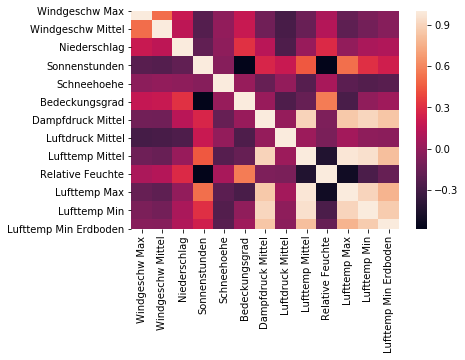

In [30]:
sns.heatmap(raw_data.corr())